In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the data directory path
data_dir = '/content/drive/MyDrive/mri'


Mounted at /content/drive


In [2]:
base_dir = '/content/drive/MyDrive/mri/train'


In [3]:
!pip install nibabel

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
from glob import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.4 MB/s eta 0:00:00


In [4]:
!pip install torch torchvision nibabel
!pip install nibabel
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np



In [5]:
import os
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.nii'):
            print(os.path.join(root, file))


/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_seg.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_flair.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t1.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t1ce.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t2.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_flair.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_t1.nii
/content/drive/MyDrive/mri/train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Tr

In [7]:
import os
import glob
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom Dataset class
class MRIDataset(Dataset):
    def __init__(self, base_dir, transform=None, sample_size=1000):
        self.transform = transform
        # Gather all image paths (consider nested folders)
        self.image_paths = glob.glob(os.path.join(base_dir, '**', '*.nii'), recursive=True)

        # Sample only up to 50 images if available
        if len(self.image_paths) > sample_size:
            self.image_paths = random.sample(self.image_paths, sample_size)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Load the MRI image as needed and apply transformations
        image_data = nib.load(image_path).get_fdata()

        # Convert to a PIL image and apply transformations if defined
        image = Image.fromarray(image_data[..., image_data.shape[2] // 2])  # Take the middle slice for 2D representation
        if self.transform:
            image = self.transform(image)

        return image

# Directory containing MRI images
base_dir = '/content/drive/MyDrive/mri/train/'

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Initialize Dataset and DataLoader
dataset = MRIDataset(base_dir=base_dir, transform=transform, sample_size=1000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check if dataloader loads correctly
for i, batch in enumerate(dataloader):
    print(f"Batch {i+1} loaded with shape: {batch.shape}")
    if i == 1:  # Just load two batches to verify
        break


Batch 1 loaded with shape: torch.Size([64, 1, 256, 256])
Batch 2 loaded with shape: torch.Size([64, 1, 256, 256])


In [8]:
import torch
import torch.nn as nn

# Define the Generator model
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)

 # Set up the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Initialize the models
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)

# Display model architectures
print("Generator model summary:")
print(G)
print("\nDiscriminator model summary:")
print(D)


Using device: cpu
Generator model summary:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Discriminator model summary:
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negativ

In [10]:
from torch import optim
from torchvision.utils import save_image
from PIL import Image  # Add this import for PIL image handling


# Training parameters
num_epochs = 1000  # Set this lower initially, like 10, for testing if RAM is a concern
batch_size = 64
learning_rate = 0.00005  # Lower learning rate often works better with WGAN
n_critic = 5  # Number of updates for Discriminator per Generator update
clip_value = 0.01  # Clipping value for weights in WGAN

# Optimizers
optimizer_D = optim.RMSprop(D.parameters(), lr=learning_rate)
optimizer_G = optim.RMSprop(G.parameters(), lr=learning_rate)

# Start the training loop
for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):  # Only unpack the image
        # Move real images to the selected device
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train the Discriminator
        optimizer_D.zero_grad()

        # Generate noise and create fake images
        noise = torch.randn(real_images.size(0), noise_dim, 1, 1, device=device)
        fake_images = G(noise).detach()

        # Calculate D's loss on real and fake images
        loss_D_real = -torch.mean(D(real_images))
        loss_D_fake = torch.mean(D(fake_images))
        loss_D = loss_D_real + loss_D_fake

        # Backprop and update Discriminator weights
        loss_D.backward()
        optimizer_D.step()

        # Clip Discriminator weights for WGAN
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the Generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Generate fake images for the Generator
            fake_images = G(noise)
            loss_G = -torch.mean(D(fake_images))

            # Backprop and update Generator weights
            loss_G.backward()
            optimizer_G.step()

    # Print the losses
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    # Optional: Save some generated images to observe progress
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_images = G(noise).cpu()
            save_image(fake_images[:16], f"generated_images_epoch_{epoch}.png", nrow=4, normalize=True)
# Save the trained generator
torch.save(G.state_dict(), "trained_generator.pth")

print("Training completed!")


Epoch [1/1000] Loss D: -0.05132704973220825, Loss G: 0.05112667754292488
Epoch [2/1000] Loss D: -0.08493500202894211, Loss G: 0.07889056205749512
Epoch [3/1000] Loss D: -0.10617118328809738, Loss G: 0.0965181440114975
Epoch [4/1000] Loss D: -0.12043233215808868, Loss G: 0.10848082602024078
Epoch [5/1000] Loss D: -0.1324884295463562, Loss G: 0.11743120849132538
Epoch [6/1000] Loss D: -0.14133229851722717, Loss G: 0.12357459217309952
Epoch [7/1000] Loss D: -0.14943844079971313, Loss G: 0.1293184459209442
Epoch [8/1000] Loss D: -0.1555655300617218, Loss G: 0.13369566202163696
Epoch [9/1000] Loss D: -0.1619289517402649, Loss G: 0.1378103494644165
Epoch [10/1000] Loss D: -0.16556987166404724, Loss G: 0.14143960177898407
Epoch [11/1000] Loss D: -0.17071513831615448, Loss G: 0.14472006261348724
Epoch [12/1000] Loss D: -0.17393623292446136, Loss G: 0.1477997601032257
Epoch [13/1000] Loss D: -0.17663219571113586, Loss G: 0.15058742463588715
Epoch [14/1000] Loss D: -0.1793711632490158, Loss G: 0

KeyboardInterrupt: 

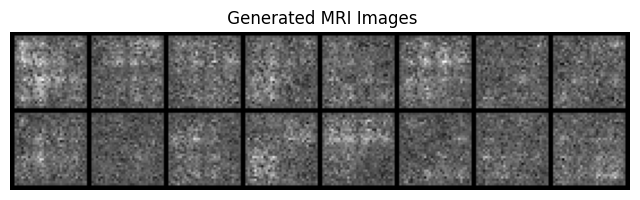

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Display a batch of generated images
def display_generated_images(images, title="Generated Images"):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Fetch a batch of generated images and display them
noise = torch.randn(16, noise_dim, 1, 1, device=device)  # Adjust batch size if needed
with torch.no_grad():
    fake_images = G(noise).detach().cpu()

display_generated_images(fake_images, title=" Generated MRI Images")


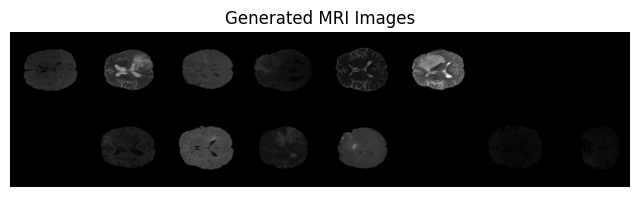

In [13]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display a batch of MRI images
def display_mri_images(images, title="Generated MRI Images"):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    # Use torchvision's make_grid to create a grid of images
    plt.imshow(
        np.transpose(
            vutils.make_grid(images[:16], padding=2, normalize=True).cpu(),
            (1, 2, 0)
        )
    )
    plt.show()

data_iter = iter(dataloader)
batch = next(data_iter)
if isinstance(batch, tuple):
    real_images = batch[0]
else:
    real_images = batch
# Display the batch generated MRI images
display_mri_images(real_images, title="Generated MRI Images")


In [16]:
torch.save(G.state_dict(), 'generator.pth')


In [17]:
G = Generator().to(device)  # Initialize the generator
G.load_state_dict(torch.load('generator.pth'))  # Load the saved state dictionary
G.eval()  # Set the generator to evaluation mode


<ipython-input-17-d18594e99bf0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator.pth'))  # Load the saved state dictionary


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [21]:
import nibabel as nib
import numpy as np
from torchvision.utils import save_image

def enhance_mri(input_nii_path, output_dir):
    # Load the NIfTI file
    nifti_data = nib.load(input_nii_path)
    image_data = nifti_data.get_fdata()  # Get the image data as a NumPy array

    # Process each slice
    for i in range(image_data.shape[2]):  # Iterate over the third dimension (slices)
        slice_data = image_data[:, :, i]

        # Normalize the slice to 0-1 range and convert to tensor
        slice_tensor = torch.tensor(slice_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add channel and batch dimensions
        slice_tensor = (slice_tensor - slice_tensor.min()) / (slice_tensor.max() - slice_tensor.min())  # Normalize to 0-1

        # Reshape slice_tensor to match the expected input channels of the Generator
        slice_tensor = slice_tensor.repeat(1, 100, 1, 1)  # Repeat the slice along the channel dimension 100 times


        # Enhance the slice using the generator
        with torch.no_grad():
            enhanced_slice = G(slice_tensor)

        # Post-process and save the enhanced slice
        enhanced_slice = enhanced_slice.squeeze(0).cpu()
        save_image(enhanced_slice, os.path.join(output_dir, f"enhanced_slice_{i}.png"))

    print(f"Enhanced MRI slices saved to: {output_dir}")

# Example usage
input_nii_path = '/content/drive/MyDrive/mri/valid/valid/valid/valid.nii'
output_dir = '/content/drive/MyDrive/mri/output/'
os.makedirs(output_dir, exist_ok=True)
enhance_mri(input_nii_path, output_dir)

KeyboardInterrupt: 